# Import libraries

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error
import copy

In [ ]:
SUB_IMAGE_SIZE = 21
TARGET_SIZE = 21
SCALE = 4
STRIDE = 15

# Load dataset

In [ ]:
# Unzip datasets
!unzip "/content/T91.zip" -d "/content/"
!unzip "/content/Set14.zip" -d "/content/"
!unzip "/content/Set5.zip" -d "/content/"

In [ ]:
def normalize(img):
  return img.astype(np.float32) / 255
    
def modcrop(img):
  size = img.shape
  size -= np.mod(size, SCALE)
  img = img[0:size[0], 0:size[1], 0]
  return img

def modcrop_color(image):
  size = image.shape
  size -= np.mod(size, SCALE)
  image = image[0:size[0], 0:size[1], :]
  return image


def unNormalize(img):
  img = img * 255
  img[img > 255] = 255
  img[img < 0] = 0
  return img.astype(np.uint8)


# Load images function
def load_images(filepath):
  print("\nLoading train images...")
  
  lr_images = []
  ilr_images = []
  hr_images = []
  residuals = []
  for file in glob.glob(filepath + "*.bmp"):
    #Read image
    img = cv2.imread(file)

    #From BGR to YCB_CR -> crop -> normalize between 0 and 1
    #img = normalize(modcrop(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)))
    img = normalize(modcrop(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)))

    img_rot = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    
    # Create low-resolution and interpolated-low-resoution images
    lr_img = cv2.resize(img, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)
    ilr_img = cv2.resize(lr_img, None, fx = SCALE ,fy = SCALE, interpolation = cv2.INTER_CUBIC)

    lr_img_rot = cv2.resize(img_rot, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)
    ilr_img_rot = cv2.resize(lr_img_rot, None, fx = SCALE ,fy = SCALE, interpolation = cv2.INTER_CUBIC)
    
    #Add images
    hr_images.append(img)
    ilr_images.append(ilr_img)
    lr_images.append(lr_img)
    residuals.append(cv2.subtract(img, ilr_img, dtype = cv2.CV_32F))

    hr_images.append(img_rot)
    ilr_images.append(ilr_img_rot)
    lr_images.append(lr_img_rot)
    residuals.append(cv2.subtract(img_rot, ilr_img_rot, dtype = cv2.CV_32F))

  print("\nDataset loaded!")
  return np.array(hr_images), np.array(ilr_images), np.array(lr_images), np.array(residuals)


def make_sub_data(input_array, target_array):
    sub_input_sequence = []
    sub_target_sequence = []

    # For this network there is no padding because SUB_IMAGE_SIZE = TARGET_SIZE
    padding = int(abs(SUB_IMAGE_SIZE - TARGET_SIZE) // 2)

    for i in range(len(input_array)):
        h, w = input_array[i].shape
        input = input_array[i]
        target = target_array[i]

        # Create sub-images
        for x in range(0, h - SUB_IMAGE_SIZE, STRIDE):
            for y in range(0, w - SUB_IMAGE_SIZE, STRIDE):
                sub_input = input[x : x + SUB_IMAGE_SIZE, y : y + SUB_IMAGE_SIZE]
                sub_target = target[x + padding : x + padding + TARGET_SIZE, y + padding : y + padding + TARGET_SIZE]

                sub_input = sub_input.reshape((SUB_IMAGE_SIZE, SUB_IMAGE_SIZE, 1)) 
                sub_target = sub_target.reshape([TARGET_SIZE, TARGET_SIZE, 1])

        
                sub_input_sequence.append(sub_input)
                sub_target_sequence.append(sub_target)
    print(len(sub_input_sequence))

    return np.array(sub_input_sequence), np.array(sub_target_sequence)
  

def residuals(hr_set, lr_set):
  residuals = []
  for i in range(hr_set.size):
    cv2.subtract(hr_set[i] , lr_set[i])
  return np.array(residuals)


In [ ]:
filepath_T91= '/content/T91/'
filepath_Set14= '/content/Set14/'
filepath_Set5= '/content/Set5/'


# LOAD DATASET
#hr -> High-resolution
#ilr -> Interpolated-low-resolution
#lr -> Low-resolution
#residual -> elementwise subtraction between High-resolution image and Interpolated-low-resolution
train_hr, train_ilr, train_lr, train_residual = load_images(filepath_T91)

# Create sub-images
input, target = make_sub_data(train_ilr, train_residual)


Loading train images...

Dataset loaded!
41690


# Model

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_166 (Conv2D)          (None, None, None, 64)    640       
_________________________________________________________________
conv2d_167 (Conv2D)          (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_168 (Conv2D)          (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_169 (Conv2D)          (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_170 (Conv2D)          (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_171 (Conv2D)          (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_172 (Conv2D)          (None, None, None, 64)  

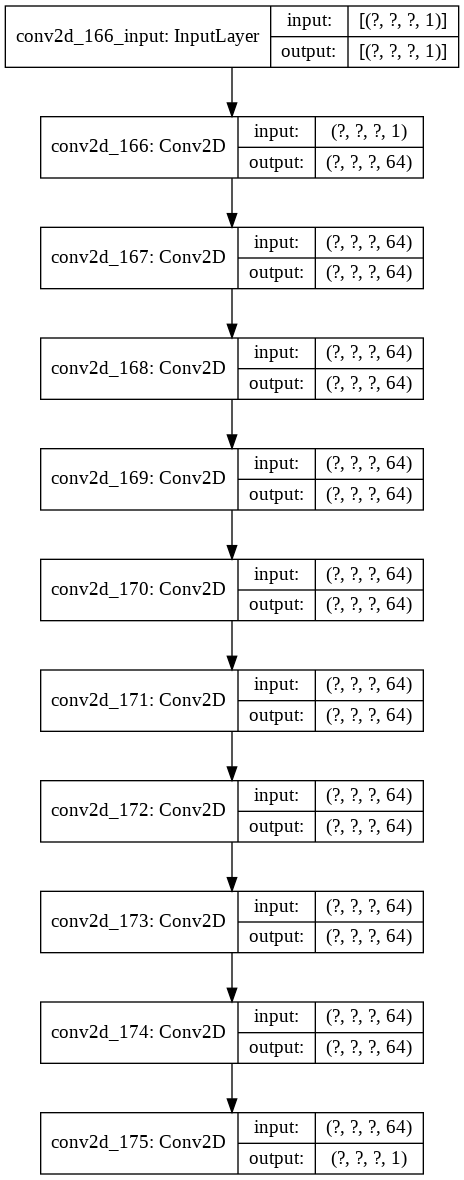

In [ ]:
vdsr = tf.keras.models.Sequential()
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(None, None, 1)))
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
vdsr.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
vdsr.add(tf.keras.layers.Conv2D(1, (3,3), padding='same', activation='linear'))

vdsr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
, loss='mean_squared_error')

vdsr.summary()
tf.keras.utils.plot_model(vdsr, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
rfall

In [ ]:
history = vdsr.fit(input, target, epochs=50, batch_size=64, 
                          shuffle=True, validation_split=0.1)

Epoch 1/50
587/587 [==============================] - 11s 19ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 2/50
587/587 [==============================] - 11s 19ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/50
587/587 [==============================] - 11s 19ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 4/50
587/587 [==============================] - 11s 19ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 5/50
587/587 [==============================] - 11s 18ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 6/50
587/587 [==============================] - 11s 19ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 7/50
587/587 [==============================] - 11s 18ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 8/50
587/587 [==============================] - 11s 18ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 9/50
587/587 [==============================] - 11s 19ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 10/50
587/587 [==============================] - 11s 19ms/step - loss: 0.004

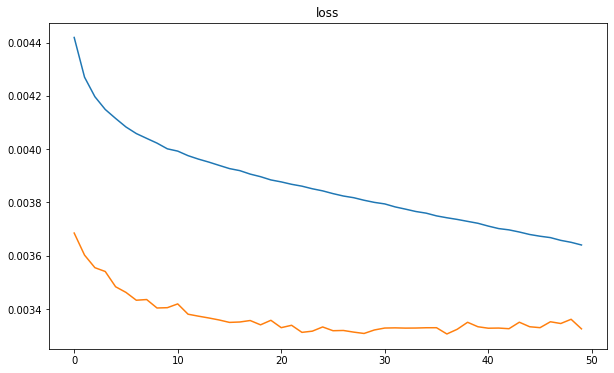

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')


plot_loss(history)

# Evaluation

In [ ]:
sum_bic_psnr = 0
sum_vdsr_psnr = 0
sum_bic_ssim = 0
sum_vdsr_ssim = 0
sum_bic_mse = 0
sum_vdsr_mse = 0
for idx, file in enumerate(glob.glob(filepath_Set5 + "*.bmp")):
  # Read and create images
  img = cv2.imread(file)
  gt_img = modcrop_color(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB))
  lr_img = cv2.resize(gt_img, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
  ilr_img = cv2.resize(lr_img, None, fx = SCALE ,fy = SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor

  #Evaluation bicubic image
  sum_bic_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_bic_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0], multichannel=True)
  sum_bic_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

  #Prediction
  Y = np.zeros((1, ilr_img.shape[0], ilr_img.shape[1], 1), dtype=float)
  Y[0,:,:,0] = normalize(ilr_img[:,:,0])
  prediction = vdsr.predict(Y, batch_size=1)

  #Image Reconstruction with VDSR
  ilr_img[:, :,0] = cv2.add(ilr_img[:,:,0] , unNormalize(prediction[0, :, :, 0]))


  #Evaluation fsrcnn output
  sum_vdsr_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_vdsr_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0])
  sum_vdsr_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

print("PSNR Bicubic Set5: ", sum_bic_psnr/5)
print("PSNR VDSR Set5: ", sum_vdsr_psnr/5)
print("\n")
print("SSIM Bicubic Set5: ", sum_bic_ssim/5)
print("SSIM VDSR Set5: ", sum_vdsr_ssim/5)
print("\n")
print("MSE Bicubic Set5: ", sum_bic_mse/5)
print("MSE VDSR Set5: ", sum_vdsr_mse/5)

PSNR Bicubic Set5:  26.332912321016703
PSNR VDSR Set5:  26.736095157238235


SSIM Bicubic Set5:  0.7715630906756044
SSIM VDSR Set5:  0.8183114748321498


MSE Bicubic Set5:  227.5090933772551
MSE VDSR Set5:  201.49755515932662


In [ ]:
sum_bic_psnr = 0
sum_vdsr_psnr = 0
sum_bic_ssim = 0
sum_vdsr_ssim = 0
sum_bic_mse = 0
sum_vdsr_mse = 0
for idx, file in enumerate(glob.glob(filepath_Set14 + "*.bmp")):
  # Read and create images
  img = cv2.imread(file)
  gt_img = modcrop_color(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB))
  lr_img = cv2.resize(gt_img, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
  ilr_img = cv2.resize(lr_img, None, fx = SCALE ,fy = SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor

  #Evaluation bicubic image
  sum_bic_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_bic_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0], multichannel=True)
  sum_bic_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

  #Prediction
  Y = np.zeros((1, ilr_img.shape[0], ilr_img.shape[1], 1), dtype=float)
  Y[0,:,:,0] = normalize(ilr_img[:,:,0])
  prediction = vdsr.predict(Y, batch_size=1)

  #Image Reconstruction with VDSR
  ilr_img[:, :,0] = cv2.add(ilr_img[:,:,0] , unNormalize(prediction[0, :, :, 0]))

  #Evaluation fsrcnn output
  sum_vdsr_psnr += peak_signal_noise_ratio(gt_img[:,:,0], ilr_img[:,:,0])
  sum_vdsr_ssim += structural_similarity(gt_img[:,:,0], ilr_img[:,:,0], multichannel=True)
  sum_vdsr_mse += mean_squared_error(gt_img[:,:,0], ilr_img[:,:,0])

print("PSNR Bicubic Set14: ", sum_bic_psnr/14)
print("PSNR VDSR Set14: ", sum_vdsr_psnr/14)
print("\n")
print("SSIM Bicubic Set14: ", sum_bic_ssim/14)
print("SSIM VDSR Set14: ", sum_vdsr_ssim/14)
print("\n")
print("MSE Bicubic Set14: ", sum_bic_mse/14)
print("MSE VDSR Set14: ", sum_vdsr_mse/14)

PSNR Bicubic Set14:  23.388688587971103
PSNR VDSR Set14:  23.68248546605866


SSIM Bicubic Set14:  0.6678306794890394
SSIM VDSR Set14:  0.678323360020223


MSE Bicubic Set14:  369.6916678145317
MSE VDSR Set14:  348.1584350365004


In [ ]:
img = cv2.imread("/content/Set5/butterfly_GT.bmp")
gt_img = modcrop_color(cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB))
lr_img = cv2.resize(gt_img, None, fx = 1.0/SCALE ,fy = 1.0/SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
ilr_img = cv2.resize(lr_img, None, fx = SCALE ,fy = SCALE, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
Y = np.zeros((1, ilr_img.shape[0], ilr_img.shape[1], 1), dtype=float)
Y[0,:,:,0] = normalize(ilr_img[:,:,0])
prediction = vdsr.predict(Y, batch_size=1)
cv2_imshow(unNormalize(prediction[0,:,:,0]))
cv2_imshow(unNormalize(prediction[0,:,:,0])*2) #contrast enhancement
cv2_imshow(cv2.cvtColor(ilr_img, cv2.COLOR_YCR_CB2BGR)) 
#Image Reconstruction with VDSR
ilr_img[:, :,0] = cv2.add(ilr_img[:,:,0] , unNormalize(prediction[0, :, :, 0]))
cv2_imshow(cv2.cvtColor(ilr_img, cv2.COLOR_YCR_CB2BGR))
cv2_imshow(cv2.cvtColor(gt_img, cv2.COLOR_YCR_CB2BGR)) 